In [1]:
from src_2020.Parser import parse

def examine(filename):
    nb_books, nb_lib, nb_days, scores, libs,books = parse(filename)
    print(filename)
    print(nb_books,"books")
    print(nb_lib,"libraries")
    print(nb_days,"days")
    print("scores",scores[:10],"..")
    print(libs[0].interest1(1))
    print("--\n")
    
examine("a_example.txt")
examine("b_read_on.txt")
examine("c_incunabula.txt")
examine("d_tough_choices.txt")
examine("e_so_many_books.txt")
examine("f_libraries_of_the_world.txt")


a_example.txt
6 books
2 libraries
7 days
scores [1, 2, 3, 6, 5, 4] ..
45.0
--

b_read_on.txt
100000 books
100 libraries
1000 days
scores [100, 100, 100, 100, 100, 100, 100, 100, 100, 100] ..
9420000000.0
--

c_incunabula.txt
100000 books
10000 libraries
100000 days
scores [524, 235, 342, 133, 537, 438, 97, 198, 104, 100] ..
0
--

d_tough_choices.txt
78600 books
30000 libraries
30001 days
scores [65, 65, 65, 65, 65, 65, 65, 65, 65, 65] ..
11960000.0
--

e_so_many_books.txt
100000 books
1000 libraries
200 days
scores [51, 127, 187, 161, 26, 140, 160, 180, 207, 164] ..
0
--

f_libraries_of_the_world.txt
100000 books
1000 libraries
700 days
scores [277, 467, 206, 176, 115, 41, 251, 677, 367, 307] ..
0
--



In [82]:
%matplotlib inline
import seaborn as sns
import pandas as pd
"""
focus on e
"""
nb_books, nb_libs, nb_days, scores, libs, books = parse("e_so_many_books.txt")
libs_books_values = []
libs_nb_books = []
mean_lib_books_scores = []
sum_lib_books_scores = []
for lib in libs[:1000]:
    libs_books_values += [[scores[book.ide] for book in lib.books]]
    total_score = sum([scores[book.ide] for book in lib.books]) 
    mean_score = total_score / len(lib.books)
    mean_lib_books_scores += [mean_score]
    libs_nb_books += [len(lib.books)]
    sum_lib_books_scores += [total_score]
    for book in lib.books:
        score = scores[book.ide]
        if score < 0:
            print("negative score?",score)
    
dc = dict([(i,pd.Series(libs_books_values[i])) for i in range(len(libs_books_values))])
#print(dc)
df = pd.DataFrame(data=dc)
#print(df)


Text(0.5, 1.0, 'boxplot of books scores per library')

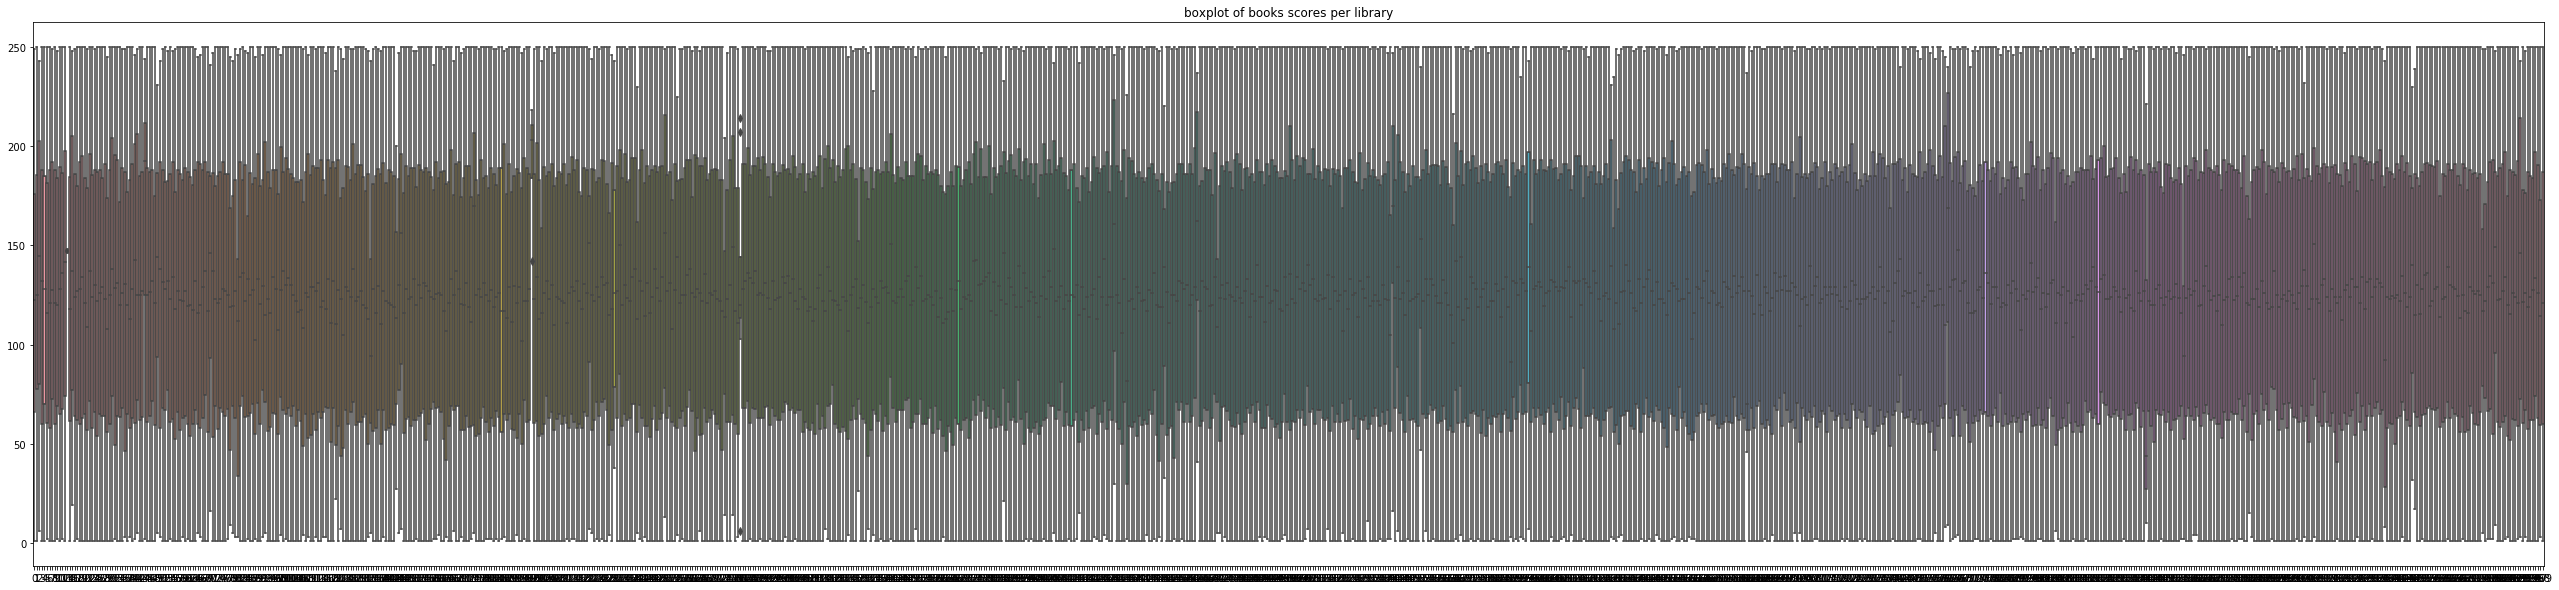

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize=(45,10))
sns.boxplot(data=df).set_title('boxplot of books scores per library')

Text(0.5, 1.0, 'histogram of mean score per library')

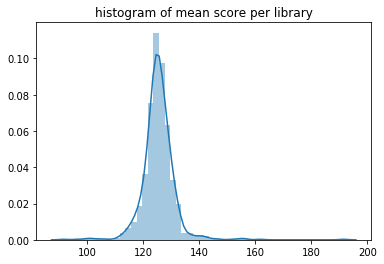

In [85]:
sns.distplot(mean_lib_books_scores).set_title('histogram of mean book score per library')

Text(0.5, 1.0, 'histogram of number of books per  library')

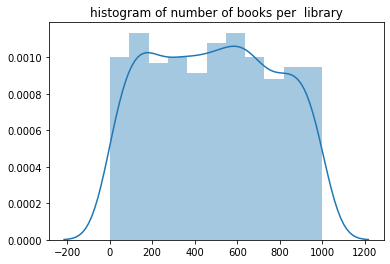

In [86]:
sns.distplot(libs_nb_books).set_title('histogram of number of books per  library')

Text(0.5, 1.0, 'histogram of total scores among books per library')

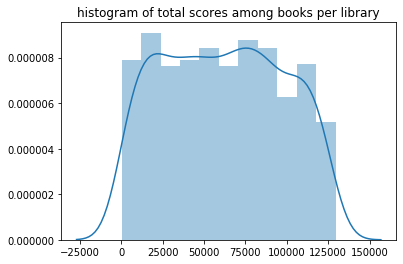

In [87]:
sns.distplot(sum_lib_books_scores).set_title('histogram of total scores among books per library')